# TestCase3 - ErrorMap

In [1]:
# sélection du cas test
testcase = 3
size_param = "big"
assert size_param in ["small","medium","big"]
largenet = True
degree = 1
n_params = 4

**Idée :** On se place ici dans le TestCase3.

On cherche à afficher des cartes d'erreur sur la solution.

## Imports + Load

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import dolfin as df
import seaborn as sns

# from modules.fenics_expressions import UexExpr
from scimba.equations.domain import SpaceTensor
from scimba.equations import domain

from modules.utils import create_tree
from modules.geometry import Square
from modules.fenics_expressions_3 import FExpr,AnisotropyExpr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


Using device: cuda
cuda devices:        1
cuda current device: 0
cuda device name:    NVIDIA RTX 2000 Ada Generation Laptop GPU


In [4]:
if testcase == 3:
    from modules.testcases.d2.test_3.test_3_v1 import Run_laplacian2D,Poisson_2D
    from modules.problem import TestCase3,TestCase3_small_param,TestCase3_medium_param
    from modules.solver_fem_3 import FEMSolver
    
    if size_param == "big":
        problem = TestCase3()
    elif size_param == "medium":
        problem = TestCase3_medium_param()
    else:
        problem = TestCase3_small_param()
else:
    raise ValueError("Testcase not found")


dim_params = problem.nb_parameters
result_dir = "../../../results/2D/testcase"+str(testcase)+"/"+size_param
if size_param == "medium" and largenet:
    result_dir += "_largenet"
result_dir += "/errormap/"
create_tree(result_dir)

tab_nb_vert = [20,40]
tab_h = []
for nb_vert in tab_nb_vert:
    solver = FEMSolver(nb_cell=nb_vert-1, params=[[]], problem=problem, degree=degree)
    tab_h.append(np.round(solver.mesh.hmax(),2))

torch loaded; device is cuda
hmax =  0.07443229275647877
hmax =  0.036261886214694776


>> load network /home/flecourtier/Bureau/Article1/networks/test_fe3.pth
jsbdbshd
network loaded


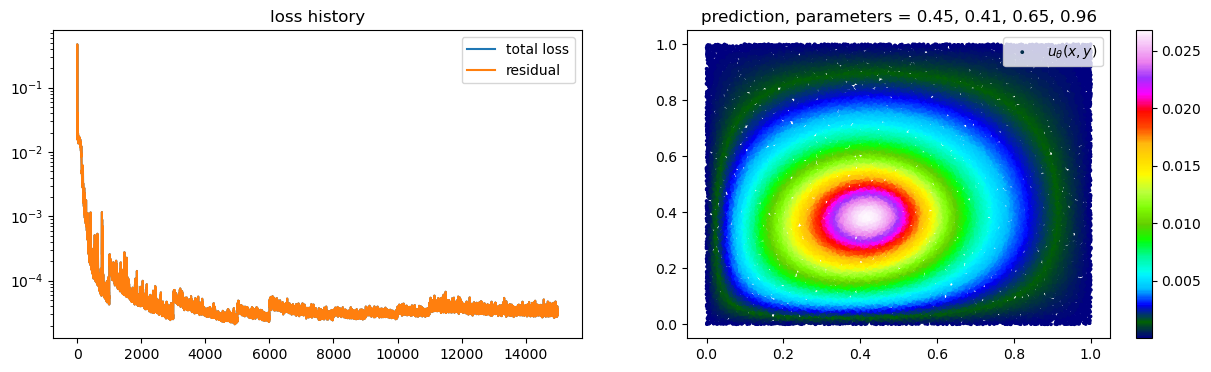

In [5]:
pde = Poisson_2D(size_param)
trainer,u_theta = Run_laplacian2D(pde,size_param,largenet)

In [6]:
def get_params(n):
    parameter_domain = trainer.pde.parameter_domain.cpu().numpy()
    # pick n random parameters for each dimension
    params = []
    for i in range(dim_params):
        parami = np.random.uniform(parameter_domain[i][0], parameter_domain[i][1], n)
        params.append(parami)
    params = np.array(params).T
    return params

np.random.seed(0)
params = get_params(n_params)
params_str = np.array([f"{params[i][0].round(2)},{params[i][1].round(2)},{params[i][2].round(2)},{params[i][3].round(2)}" for i in range(n_params)])
params

array([[0.5097627 , 0.48473096, 0.77456393, 0.57236412],
       [0.54303787, 0.52917882, 0.36840906, 0.92634067],
       [0.52055268, 0.48751744, 0.65420753, 0.0803257 ],
       [0.50897664, 0.5783546 , 0.47022644, 0.09625801]])

## Solution de référence

In [7]:
def create_ref_domain(deg):
    nb_vert = 500

    # check if pb_considered is instance of Square class
    if isinstance(problem.geometry, Square):
        box = np.array(problem.geometry.box)
        mesh_ref = df.RectangleMesh(df.Point(box[0,0], box[1,0]), df.Point(box[0,1], box[1,1]), nb_vert - 1, nb_vert - 1)
    else:
        raise ValueError("Geometry not implemented")
    
    V_ref = df.FunctionSpace(mesh_ref, "CG", deg)
    dx_ref = df.Measure("dx", domain=mesh_ref)
    
    h_ref = mesh_ref.hmax()
    print("hmax = ",h_ref)

    return mesh_ref, V_ref, dx_ref
    
def get_uref(param, mesh_ref, V_ref, dx_ref):
    
    boundary = "on_boundary"

    mat = AnisotropyExpr(param, degree=10, domain=mesh_ref, pb_considered=problem) 
    # mat = df.Expression((("eps * x[0]*x[0] + x[1]*x[1]","(eps - 1) * x[0] * x[1]"),
    #                 ("(eps - 1) * x[0] * x[1]","x[0]*x[0] + eps * x[1]*x[1]")), 
    #                 eps=param[3],
    #                 degree=10, 
    #                 domain=mesh_ref)
    
    f_expr = FExpr(param, degree=10, domain=mesh_ref, pb_considered=problem)
    
    g = df.Constant("0.0")
    bc = df.DirichletBC(V_ref, g, boundary)

    u = df.TrialFunction(V_ref)
    v = df.TestFunction(V_ref)
    
    # Resolution of the variationnal problem

    a = df.inner(mat*df.grad(u),df.grad(v)) * dx_ref
    l = f_expr * v * dx_ref

    sol = df.Function(V_ref)
    df.solve(a==l, sol, bcs=bc)

    return sol

mesh_ref, V_ref, dx_ref = create_ref_domain(deg=2)


hmax =  0.002834095315376947


In [8]:
loadresult = True

savedir = result_dir + "u_ref/"
create_tree(savedir)

tab_u_ref = []
if not loadresult:
    for i,param in enumerate(params):
        print(i, param)
        filename = savedir + f"u_ref_{i}.npy"
        u_ref = get_uref(param, mesh_ref, V_ref, dx_ref)
        vct_u_ref = u_ref.vector().get_local()
        np.save(filename, vct_u_ref)
        tab_u_ref.append(u_ref)
else:
    for i,param in enumerate(params):
        filename = savedir + f"u_ref_{i}.npy"
        if os.path.exists(filename):
            vct_u_ref = np.load(filename)
            u_ref = df.Function(V_ref)
            u_ref.vector()[:] = vct_u_ref
            tab_u_ref.append(u_ref)
        else:
            print(i, param)
            u_ref = get_uref(param, mesh_ref, V_ref, dx_ref)
            vct_u_ref = u_ref.vector().get_local()
            np.save(filename, vct_u_ref)
            tab_u_ref.append(u_ref)
            

## Erreurs PINNs

In [9]:
def get_test_sample(i,solver,trainer,deg_PINNs):
    # get coordinates of the dof
    V_test = df.FunctionSpace(solver.mesh,"CG",deg_PINNs)
    XXYY = V_test.tabulate_dof_coordinates()
    X_test = torch.tensor(XXYY,requires_grad=True)
    X_test = SpaceTensor(X_test,torch.zeros_like(X_test,dtype=int))

    # get parameters
    nb_params = len(trainer.pde.parameter_domain)
    shape = (XXYY.shape[0],nb_params)
    ones = torch.ones(shape)
    mu_test = (torch.Tensor(params[i]).to(device) * ones).to(device)

    return V_test,X_test,mu_test

In [10]:
def read_csv_PINNs(testcase,degree):
    df_PINNs = pd.read_csv(result_dir+f'PINNs_case{testcase}_degree{degree}.csv')
    tab_err_PINNs = df_PINNs.values[2:,1:]
    
    return tab_err_PINNs

def run_PINNs(degree,new_run=False):
    csv_file = result_dir+f'PINNs_case{testcase}_degree{degree}.csv'
    col_names = [("PINNs",str(tab_nb_vert[i]),tab_h[i]) for i in range(len(tab_nb_vert))]
    mi = pd.MultiIndex.from_tuples(col_names, names=["method","n_vert","h"])
    if not new_run and os.path.exists(csv_file):
        tab_err_PINNs = read_csv_PINNs(testcase,degree)
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        print(f"Read csv file {csv_file}")
    else:
        colormap = "jet"
        tab_err_PINNs = np.zeros((n_params,len(tab_nb_vert)))

        for (j,nb_vert) in enumerate(tab_nb_vert):
            print(f"nb_vert={nb_vert}")
            solver = FEMSolver(nb_cell=nb_vert-1, params=params, problem=problem, degree=degree)
            degree_PINNs = solver.high_degree
            print("param =",end=" ")
            for i in range(n_params):
                print(i,end=" ")
                V_test,X_test,mu_test = get_test_sample(i,solver,trainer,degree_PINNs)
                pred = u_theta.setup_w_dict(X_test, mu_test)
                phi_tild = pred["w"][:,0].cpu().detach().numpy()
                
                u_PINNs = df.Function(V_test)
                u_PINNs.vector()[:] = phi_tild.copy()

                uref_Vex = df.interpolate(tab_u_ref[i],solver.V_ex)
                norme_L2 = (df.assemble((((uref_Vex - u_PINNs)) ** 2) * solver.dx) ** (0.5)) / (df.assemble((((uref_Vex)) ** 2) * solver.dx) ** (0.5))
            
                plt.figure(figsize=(15,5))
                
                plt.subplot(1,3,1)
                c = df.plot(uref_Vex,cmap=colormap)
                plt.colorbar(c)
                plt.title("uref")
                
                plt.subplot(1,3,2)
                c = df.plot(u_PINNs,cmap=colormap)
                plt.colorbar(c)
                plt.title("uPINNs")
                
                plt.subplot(1,3,3)
                error = df.Function(solver.V_ex)
                error.vector()[:] = uref_Vex.vector()[:] - u_PINNs.vector()[:]
                c = df.plot(error,cmap=colormap)
                plt.colorbar(c)
                plt.title("error {0:.2e}".format(norme_L2))
                
                plt.suptitle(f"nb_vert={nb_vert} param ({i})={params_str[i]}")
                plt.savefig(result_dir+f"errormap_{i}_N{nb_vert}.png")
                plt.show()
                tab_err_PINNs[i,j] = norme_L2
            print()

        
        df_PINNs = pd.DataFrame(tab_err_PINNs,columns=mi)
        df_PINNs.to_csv(csv_file)
        
    return df_PINNs, tab_err_PINNs

nb_vert=20
hmax =  0.07443229275647877
param = 0 

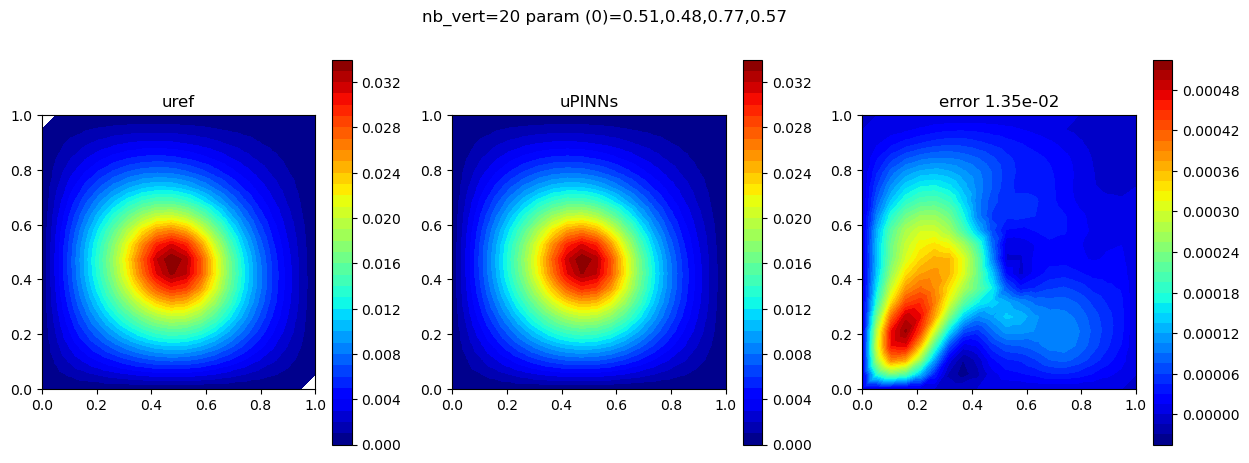

1 

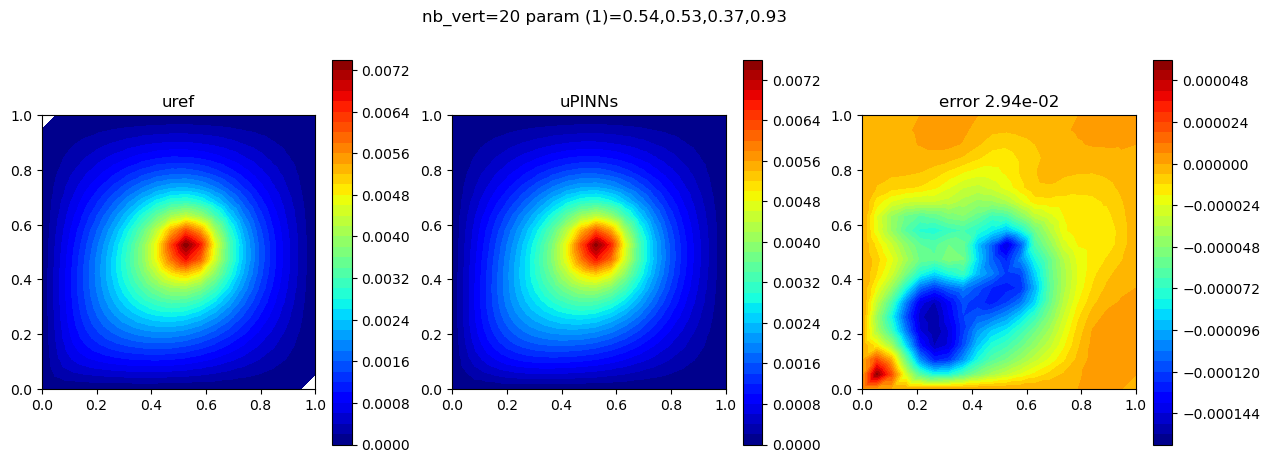

2 

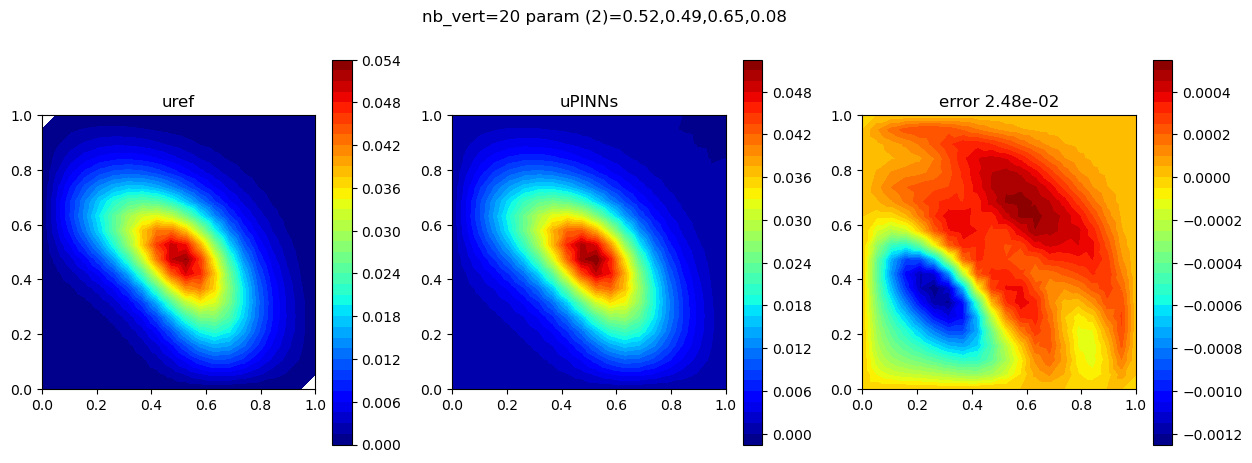

3 

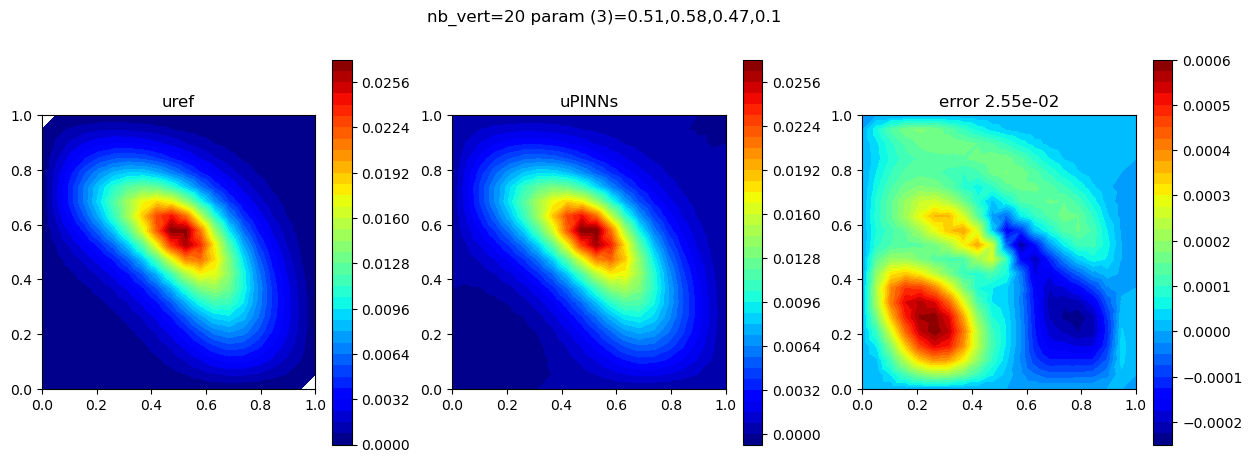


nb_vert=40
hmax =  0.036261886214694776
param = 0 

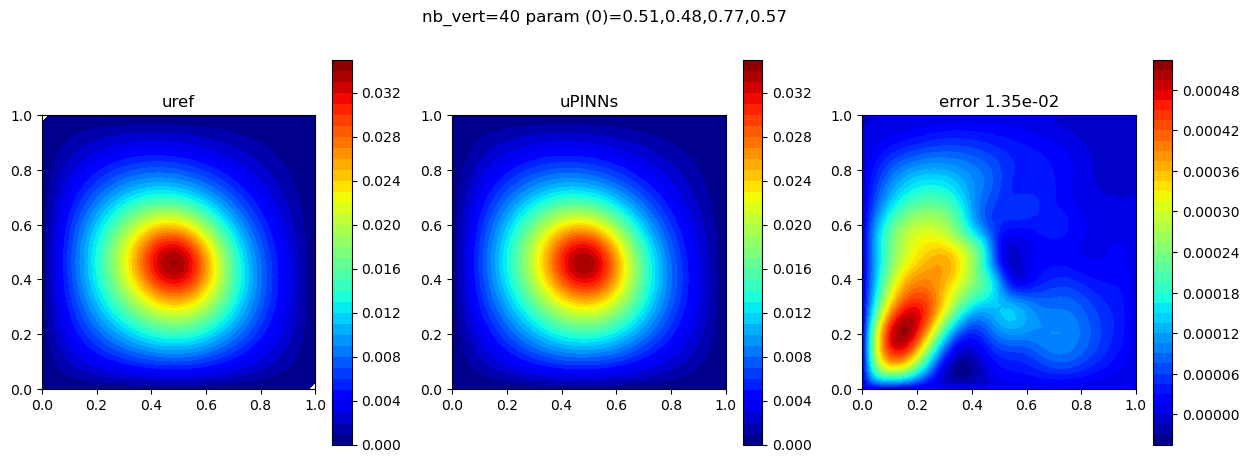

1 

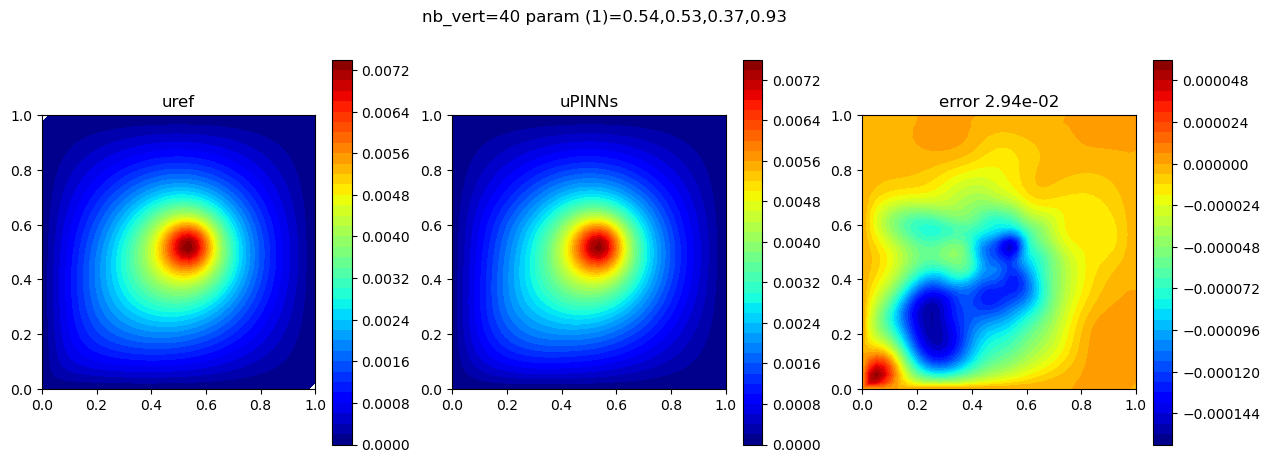

2 

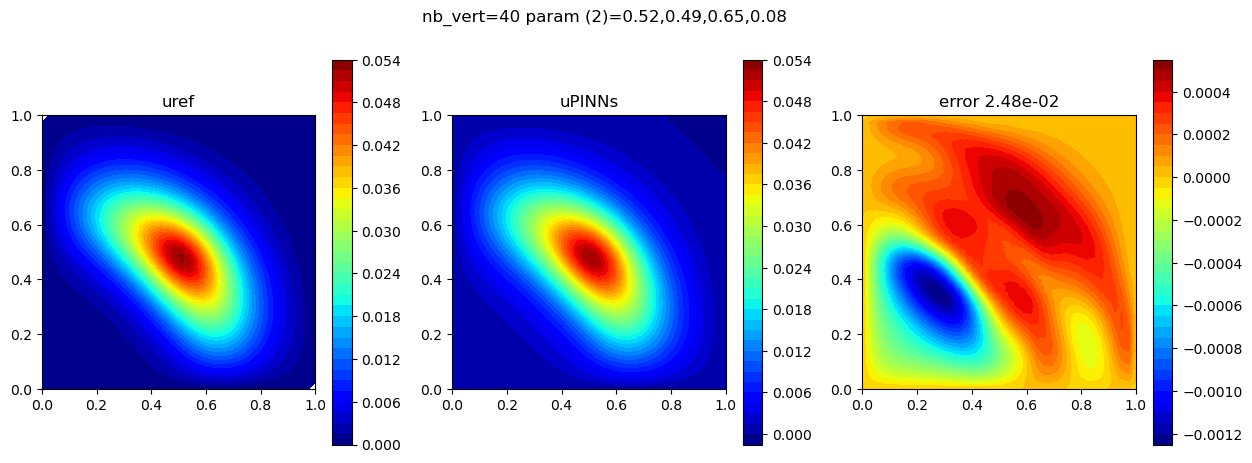

3 

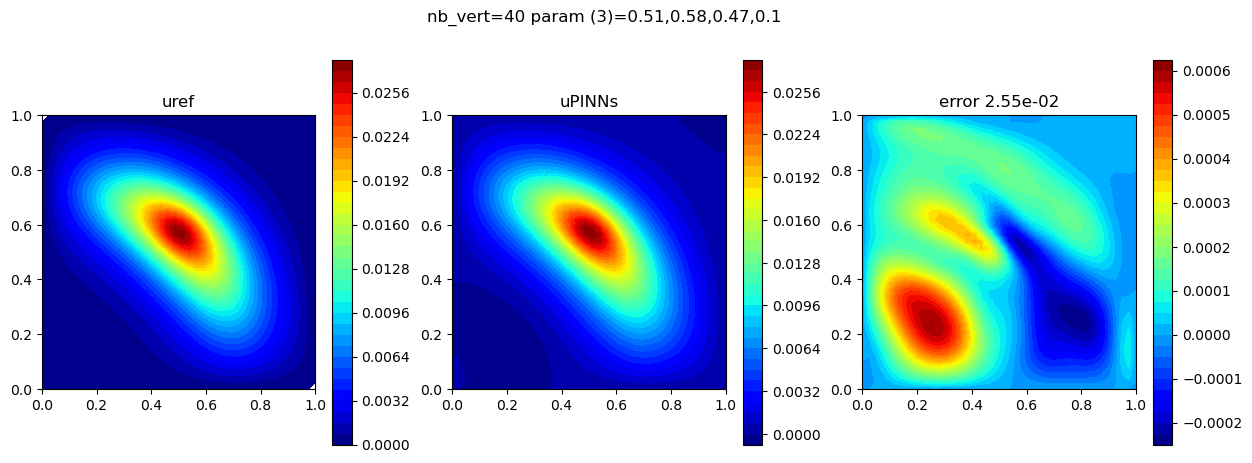

In [11]:
df_PINNs, tab_err_PINNs = run_PINNs(degree,new_run=True)